## A Portfolio of Technology Stocks in the S&P 500 using Markowitz's Modern Portfolio Theory

The objective of the project is look for the optimal portfolio which give best risk-return trade-off that lie along the minimum variance frontier within a set of given risky assets.

The assets in this case are the Technology Stocks of the S&P 500

#### Importing libraries

In [1]:
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import optimize
from random import randint
import json
import warnings
warnings.filterwarnings('ignore')

<br>

**The Historical stock datasets was downloaded in the form of cvs files from Yahoo Finanace and in the cell below, the data was read into a Pandas dataframe**


In [2]:
# Get a list of all CSV files in a directory
csv_files = glob.glob('data/*.csv')

# Create an empty dataframe to store the combined data

combined_df = pd.DataFrame()

for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    file_name = str(csv_file.split('.')[0].split('\\')[-1])
    updated_df = df[['Date', 'Close']]
    updated_df[file_name] = updated_df['Close']
    updated_df.drop(['Close'], axis=1, inplace=True)
    updated_df['Date'] = pd.to_datetime(arg=updated_df['Date'])
    updated_df.set_index('Date', inplace=True)
    
    
    combined_df = pd.concat([combined_df, updated_df], axis=1)

    
# While downloading the dataset, the ending dates considered for the stock was 30th of August but some
# stocks had their end dates beyond that.The line of code was used to make the stock end dates uniform
combined_df.drop([combined_df.index[-1], combined_df.index[-2]], inplace=True)


# Reversing the order of the sorting

<br>
<br>

### Mapping Tickers to Name of Company

**The names and symbol of the Technology companies in the S&P 500 considered for this project were stored in a dictionary and saved in a json file that is loaded in the cell below.**

**This dictionary can be used to map a specific ticker to the name of the company**

In [3]:
# Loading the dictionary containing the names and symbols of the companies

data = json.load(open( "tickersAndCompanies.json" ))

In [4]:
# Creating a dataframe with the tickers and company names

data_df = pd.DataFrame.from_dict(data, orient='index', columns=['Company_Name'])

data_df.index.name = 'Tickers'

data_df

,Company_Name
Tickers,
AAPL,Apple Inc.
ACN,Accenture plc
ADBE,Adobe Inc.
ADI,Analog Devices Inc.
ADSK,Autodesk Inc.
...,...
TXN,Texas Instruments Incorporated
TYL,Tyler Technologies Inc.
VRSN,VeriSign Inc.


<br>

### API Data

**An API call is one of the ways in which the historical dataset used in this project can be gotten which involves the use of a library such as yfinance to get the stock data from Yahoo finance**

With the api call, the data collection can be automated using the current date as the stop date of the data that is fetched with API.

This was not the method used to obtain the dataset used in this project.

Yet, it is important to point out the existence and importance of such approach.

In [5]:
""""
# Importing the library that can be used to make an API call to fetch Stock data from Yahoo finance
import yfinance as yf

# Creating an empty dataframe
combined_df = pd.DataFrame()

# Fetching the data from Yahoo finance using the API call
for ticker in data:
    df = yf.download(ticker, start="2012-01-01", end="2023-08-31")
    updated_df = df[['Close']]
    updated_df[ticker] = updated_df['Close']
    updated_df.drop(['Close'], axis=1, inplace=True)
    #updated_df['Date'] = pd.to_datetime(arg=updated_df['Date'])
    #updated_df.set_index('Date', inplace=True)
    
    # Putting the needed portion of the dataframe in a Dataframe.
    combined_df = pd.concat([combined_df, updated_df], axis=1)
    

# While downloading the dataset, the ending dates considered for the stock was 30th of August but some
# stocks had their end dates beyond that.The line of code was used to make the stock end dates uniform
combined_df.drop([combined_df.index[-1], combined_df.index[-2]], inplace=True)

"""


'"\n# Importing the library that can be used to make an API call to fetch Stock data from Yahoo finance\nimport yfinance as yf\n\n# Creating an empty dataframe\ncombined_df = pd.DataFrame()\n\n# Fetching the data from Yahoo finance using the API call\nfor ticker in data:\n    df = yf.download(ticker, start="2012-01-01", end="2023-08-31")\n    updated_df = df[[\'Close\']]\n    updated_df[ticker] = updated_df[\'Close\']\n    updated_df.drop([\'Close\'], axis=1, inplace=True)\n    #updated_df[\'Date\'] = pd.to_datetime(arg=updated_df[\'Date\'])\n    #updated_df.set_index(\'Date\', inplace=True)\n    \n    # Putting the needed portion of the dataframe in a Dataframe.\n    combined_df = pd.concat([combined_df, updated_df], axis=1)\n    \n\n# While downloading the dataset, the ending dates considered for the stock was 30th of August but some\n# stocks had their end dates beyond that.The line of code was used to make the stock end dates uniform\ncombined_df.drop([combined_df.index[-1], combin

<br>

### CSV Data (Downloaded)


**The Historical stock datasets was downloaded in the form of cvs files from Yahoo Finanace and in the cell below, the data was read into a Pandas dataframe and formatted**

**This is the form of data used in this project**

In [6]:
# Get a list of all CSV files in a directory
csv_files = glob.glob('data/*.csv')

# Create an empty dataframe to store the combined data

combined_df = pd.DataFrame()

for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    file_name = str(csv_file.split('.')[0].split('\\')[-1])
    updated_df = df[['Date', 'Close']]
    updated_df[file_name] = updated_df['Close']
    updated_df.drop(['Close'], axis=1, inplace=True)
    updated_df['Date'] = pd.to_datetime(arg=updated_df['Date'])
    updated_df.set_index('Date', inplace=True)
    
    
    combined_df = pd.concat([combined_df, updated_df], axis=1)

    
# While downloading the dataset, the ending dates considered for the stock was 30th of August but some
# stocks had their end dates beyond that.The line of code was used to make the stock end dates uniform
combined_df.drop([combined_df.index[-1], combined_df.index[-2]], inplace=True)


# Reversing the order of the sorting

<br>
<br>

## Viewing the dataset

In [7]:
combined_df.head()

,AAPL,ACN,ADBE,ADI,ADSK,AKAM,AMAT,AMD,ANET,ANSS,...,SWKS,TDY,TEL,TER,TRMB,TXN,TYL,VRSN,WDC,ZBRA
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,14.686786,52.950001,28.570000,36.029999,30.809999,32.930000,10.70,5.48,NaN,57.389999,...,16.820000,55.820000,31.480000,13.75,20.815001,29.760000,30.340000,35.820000,30.980000,35.720001
2012-01-04,14.765714,52.930000,28.280001,35.980000,30.209999,32.439999,10.76,5.46,NaN,56.400002,...,16.780001,55.790001,31.570000,14.18,20.105000,29.570000,30.360001,35.820000,31.299999,35.450001
2012-01-05,14.929643,51.919998,28.480000,36.139999,30.820000,32.430000,10.83,5.46,NaN,57.299999,...,17.280001,55.570000,31.920000,14.62,20.385000,29.780001,31.090000,35.740002,32.759998,35.400002
2012-01-06,15.085714,51.830002,28.719999,35.900002,30.959999,32.759998,11.01,5.43,NaN,56.939999,...,17.150000,55.580002,32.360001,14.63,20.075001,29.780001,31.809999,35.400002,33.490002,35.110001
2012-01-09,15.061786,51.740002,28.530001,36.599998,31.080000,32.610001,11.34,5.59,NaN,56.680000,...,17.809999,55.220001,32.810001,14.89,20.870001,30.160000,31.559999,35.020000,33.750000,34.950001


<br>
<br>
<br>

The historical stock data considered spanned ten years, using daily data - from `01-01-2012` to `30-08-2023`

The start date for stock was `03-01-2012` as the first two days of 2012 were public holidays.

According to Google, there are approximately `252 days in a year`, `21 days per month` and `12 months per year` for trading in a Stock market.

Some Technology companies on the S&P 500 do not have their stock options extend back to 2012, and they were therfore dropped from the dataset used leaving us with 52 portfolios

In [8]:
# Dropping portfolios that are not up to 10 years

combined_df.dropna(axis=1, how='any', inplace=True)

In [9]:
combined_df.sort_values(['Date'], ascending=False)

,AAPL,ACN,ADBE,ADI,ADSK,AKAM,AMAT,AMD,ANSS,AVGO,...,SWKS,TDY,TEL,TER,TRMB,TXN,TYL,VRSN,WDC,ZBRA
Date,,,,,,,,,,,,,,,,,,,,,
2023-08-30,187.649994,323.250000,545.359985,181.570007,221.550003,104.639999,150.949997,106.589996,315.959991,892.280029,...,107.980003,420.070007,131.929993,107.370003,54.250000,169.229996,397.959991,209.119995,42.520000,279.109985
2023-08-29,184.119995,323.450012,540.570007,182.559998,219.399994,104.400002,149.979996,105.919998,314.209991,889.929993,...,107.779999,417.910004,131.190002,107.370003,54.240002,170.690002,391.589996,207.350006,41.549999,273.489990
2023-08-28,180.190002,320.910004,529.919983,180.330002,217.089996,103.220001,145.419998,102.610001,308.149994,861.080017,...,106.199997,416.130005,129.750000,104.570000,53.259998,168.699997,384.250000,206.529999,41.410000,269.920013
2023-08-25,178.610001,318.760010,525.059998,178.160004,215.919998,102.820000,144.360001,102.250000,304.890015,851.820007,...,105.389999,408.549988,128.639999,103.779999,52.150002,167.809998,378.790009,205.740005,39.490002,268.390015
2023-08-24,176.380005,314.140015,512.429993,173.690002,208.600006,101.650002,142.520004,101.800003,298.559998,854.460022,...,104.230003,406.000000,127.559998,102.110001,52.259998,165.589996,375.119995,202.570007,39.869999,265.920013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-01-09,15.061786,51.740002,28.530001,36.599998,31.080000,32.610001,11.340000,5.590000,56.680000,30.219999,...,17.809999,55.220001,32.810001,14.890000,20.870001,30.160000,31.559999,35.020000,33.750000,34.950001
2012-01-06,15.085714,51.830002,28.719999,35.900002,30.959999,32.759998,11.010000,5.430000,56.939999,28.309999,...,17.150000,55.580002,32.360001,14.630000,20.075001,29.780001,31.809999,35.400002,33.490002,35.110001
2012-01-05,14.929643,51.919998,28.480000,36.139999,30.820000,32.430000,10.830000,5.460000,57.299999,28.490000,...,17.280001,55.570000,31.920000,14.620000,20.385000,29.780001,31.090000,35.740002,32.759998,35.400002


In [10]:
Tickers = combined_df.columns

In [11]:
Tickers

Index(['AAPL', 'ACN', 'ADBE', 'ADI', 'ADSK', 'AKAM', 'AMAT', 'AMD', 'ANSS',
       'AVGO', 'CDNS', 'CRM', 'CSCO', 'CTSH', 'FFIV', 'FICO', 'FSLR', 'FTNT',
       'GEN', 'GLW', 'HPQ', 'IBM', 'INTC', 'INTU', 'IT', 'JNPR', 'KLAC',
       'LRCX', 'MCHP', 'MPWR', 'MSFT', 'MSI', 'MU', 'NTAP', 'NVDA', 'NXPI',
       'ON', 'ORCL', 'PTC', 'QCOM', 'SNPS', 'STX', 'SWKS', 'TDY', 'TEL', 'TER',
       'TRMB', 'TXN', 'TYL', 'VRSN', 'WDC', 'ZBRA'],
      dtype='object')

<br>
<br>

# Exploratory Data Analysis

**Viewing the info of the dataset to ensure that the available data is consistent**

The Exploratory Data Analysis is restricted to assests that were used in the Portfolio Optimization

In [12]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2934 entries, 2012-01-03 to 2023-08-30
Data columns (total 52 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    2934 non-null   float64
 1   ACN     2934 non-null   float64
 2   ADBE    2934 non-null   float64
 3   ADI     2934 non-null   float64
 4   ADSK    2934 non-null   float64
 5   AKAM    2934 non-null   float64
 6   AMAT    2934 non-null   float64
 7   AMD     2934 non-null   float64
 8   ANSS    2934 non-null   float64
 9   AVGO    2934 non-null   float64
 10  CDNS    2934 non-null   float64
 11  CRM     2934 non-null   float64
 12  CSCO    2934 non-null   float64
 13  CTSH    2934 non-null   float64
 14  FFIV    2934 non-null   float64
 15  FICO    2934 non-null   float64
 16  FSLR    2934 non-null   float64
 17  FTNT    2934 non-null   float64
 18  GEN     2934 non-null   float64
 19  GLW     2934 non-null   float64
 20  HPQ     2934 non-null   float64
 21  IBM     2934 non-nu

## Visualizing the Historical Price data of the different Assets

In [13]:
def plotCharts(chartData, chartTitle, df=data):
    '''
        A function created to plot multiple subplots charts of a given dataframe
        
        Input:
                chartData: A 2-dimensional array. The dataframe to plotted.
    '''

    def random_with_N_digits(n):
    
        '''
            A function to generate a specific number of digits
            Ths function was included to generate random codes used for the colors of the plots
        '''
    
        range_start = 10**(n-1)
        range_end = (10**n)-1
        return randint(range_start, range_end)
    
    
    for i in range(int(len(chartData.columns)/4)):
        print('\n')
        fig = f'fig{i}'
        axs = f'ax{i}'
        #fig = plt.figure(figsize=(20, 16))
        fig, axs = plt.subplots(2, 2, figsize=(10, 8))
    
        k = i*3
        plotValues = []
    
        for j in range(4):
            plotValues.append(chartData.columns[i+j+k])
        
        
        if i == 0:
            fig.suptitle(f'{chartTitle}', fontsize=15)
            
        axs[0, 0].plot(chartData[plotValues[0]], color=f'#{random_with_N_digits(4)}cc')
        axs[0, 0].set_title(data[plotValues[0]])
        axs[0, 1].plot(chartData[plotValues[1]], color=f'#dc{random_with_N_digits(4)}')
        axs[0, 1].set_title(data[plotValues[1]])
        axs[1, 0].plot(chartData[plotValues[2]], color=f'#00{random_with_N_digits(2)}3d')
        axs[1, 0].set_title(data[plotValues[2]])
        axs[1, 1].plot(chartData[plotValues[3]], color=f'#ffb2{random_with_N_digits(2)}')
        axs[1, 1].set_title(data[plotValues[3]])

        for ax in axs.flat:
            if ax == axs.flat[2] or ax == axs.flat[3]:
                ax.set(xlabel='x-label')
            ax.set(ylabel='y-label')
        
        # Adding title to the plots
            
    
        plt.tight_layout(pad=5.0)
        plt.show()

<br>
<br>

## Plotting the Charts

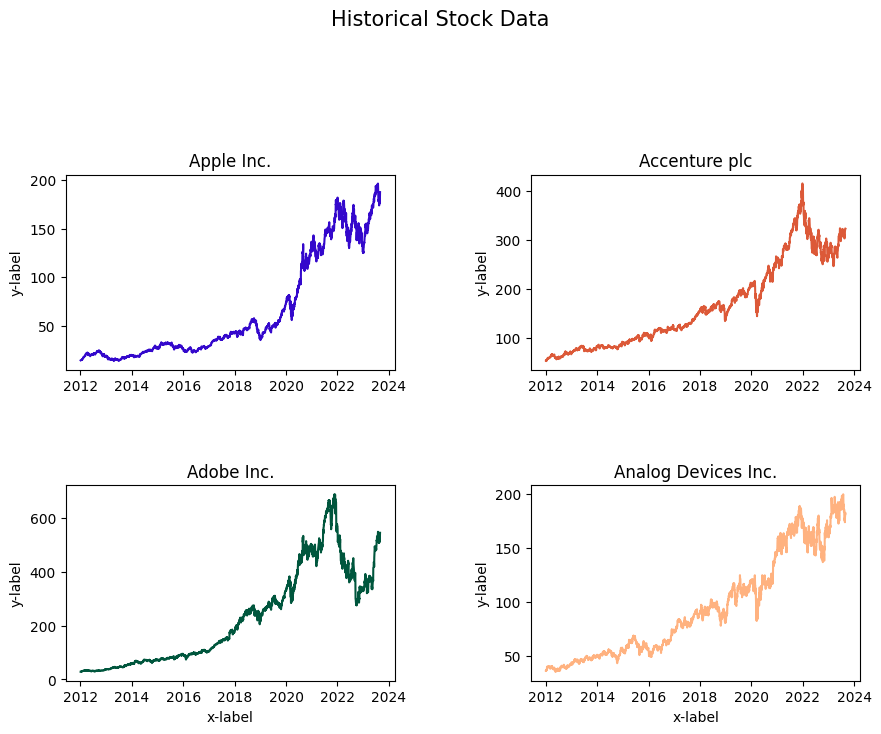

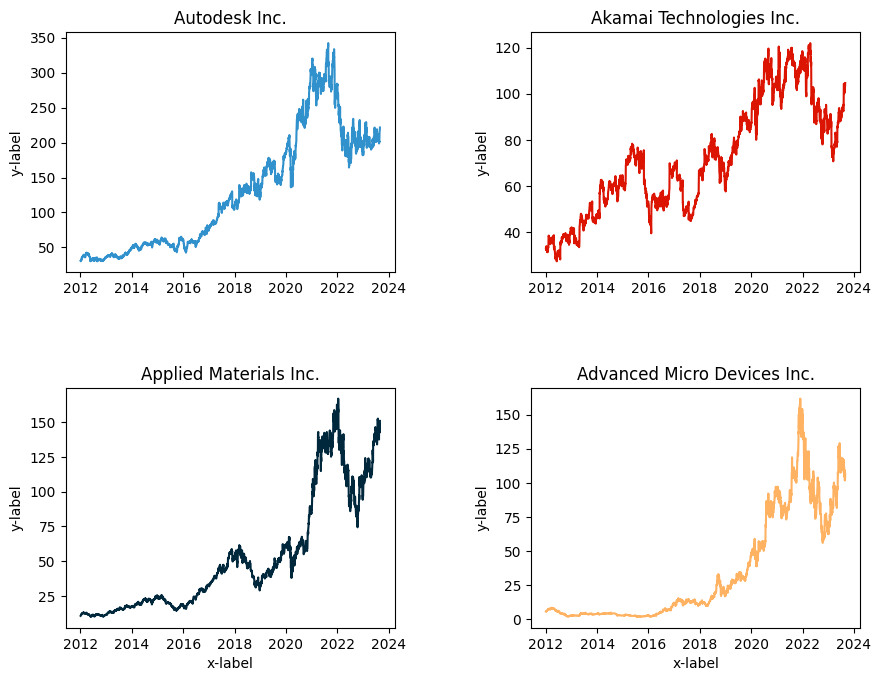

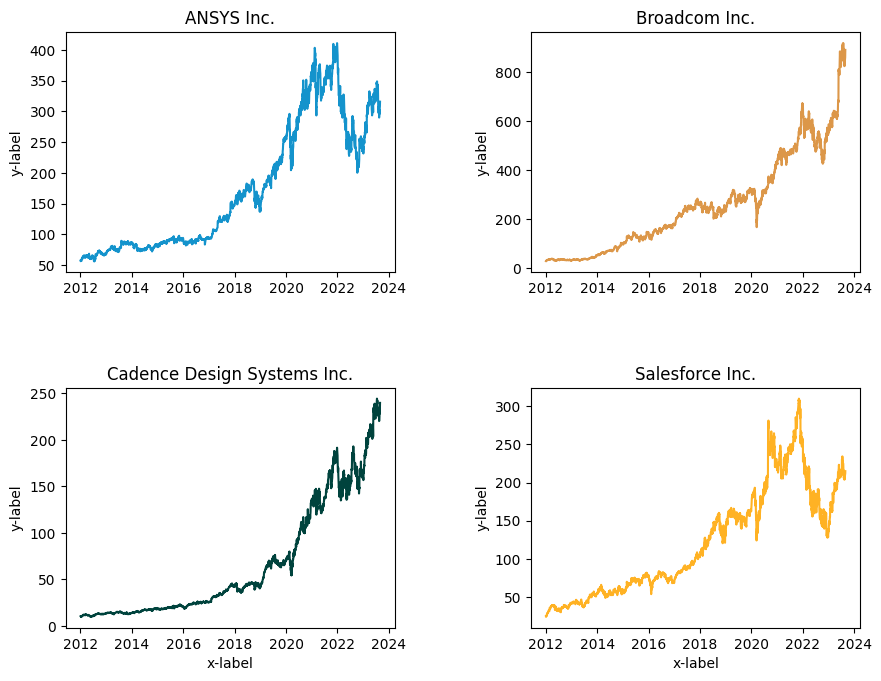

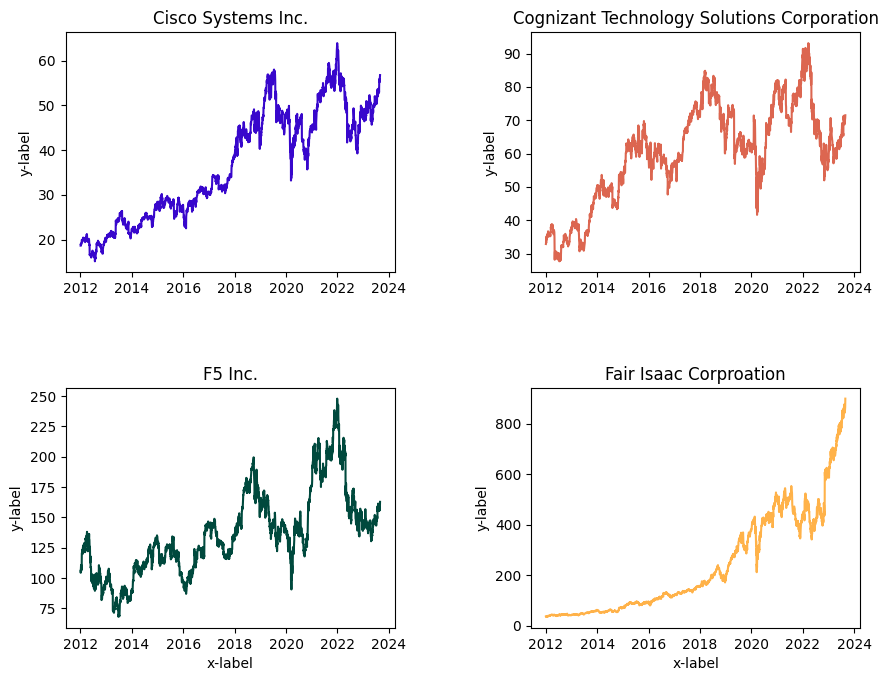

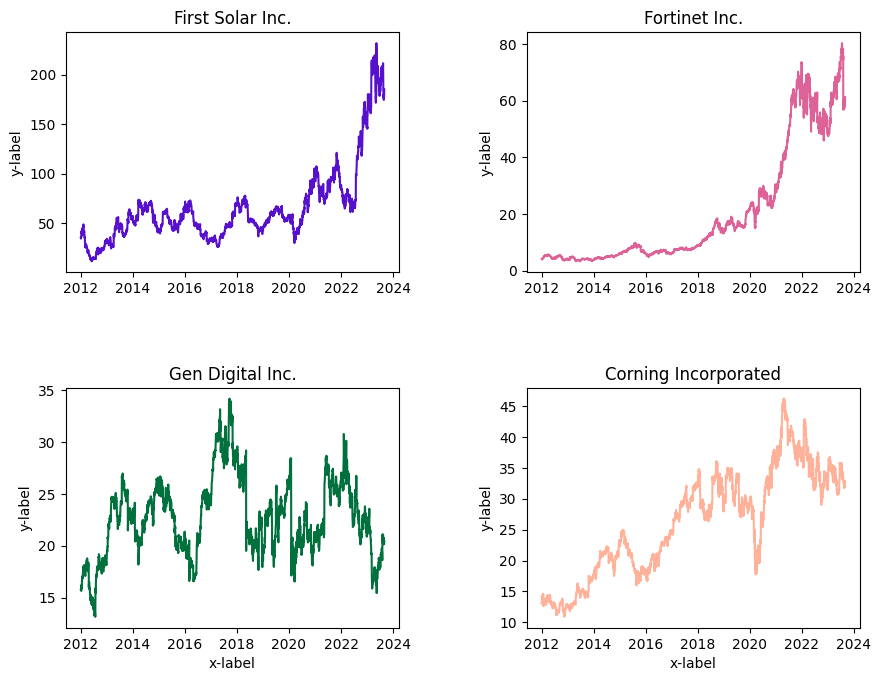

In [ ]:
plotCharts(combined_df, 'Historical Stock Data')

# Implementation of the Markowitz's Modern Portfolio Theory

52 Portfolios of Technology companies from the S&P 500 are being considered

#### Important parameters


`Expected return for a portfolio` = `Transpose of weights of the assets within the portfolio` * `Expected return`

`StandardDeviation` or `Volatility` = squar root of (`Transpose of Weights of assets` * `variance-covariance` * `Weights of assests`)

`Risk free rate` is a return an investor can expect from an investment, given the risk associated is zero.

`Sharpe ratio` is a measure of risk-adjusted return

`Sharpe ratio` = (`ExpectedReturn` - `RiskFreeRate`) / `Variance`



<br>

## Daily Returns

<br>

The returns using the daily dataset was obtained for the individual portfolio.

In [ ]:
RiskFreeRate = 3.8/100.0

In [ ]:
# Get a list of all CSV files in a directory
csv_files = glob.glob('data/*.csv')

# Create an empty dataframe to store the combined data

daily_returns = pd.DataFrame()

for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    file_name = str(csv_file.split('.')[0].split('\\')[-1])
    if file_name in list(combined_df.columns):
        ind_daily_return = pd.DataFrame(combined_df[file_name].pct_change())
        daily_returns = pd.concat([daily_returns, ind_daily_return], axis=1)

In [ ]:
# viewing the origin dataframe after calculating daily returns

daily_returns.head()

In [ ]:
# This was written to view the dataframe from the current to the earliest dates, that is, reversing the order of the dataframe
# And the multiplication by 100 was done to express the returns as percentages which is the required way to express them

daily_returns = daily_returns.sort_values(['Date'], ascending=False)
daily_returns.head().mul(100)

<br>
<br>

## Charting the Daily Returns Data

In [ ]:
plotCharts(daily_returns, 'Daily Returns')

<br>
<br>

## Monthly Returns

The percentage returns per month for each portfolio.

**The `'M'` passed into the resample function was used to achieve this**

In [ ]:
# Get a list of all CSV files in a directory
csv_files = glob.glob('data/*.csv')

# Create an empty dataframe to store the combined data

monthly_returns = pd.DataFrame()

for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    file_name = str(csv_file.split('.')[0].split('\\')[-1])
    if file_name in list(combined_df.columns):
        ind_monthly_return = pd.DataFrame(combined_df[file_name].resample('M').ffill().pct_change())
        monthly_returns = pd.concat([monthly_returns, ind_monthly_return], axis=1)


In [ ]:
monthly_returns = monthly_returns.sort_values(['Date'], ascending=False)
monthly_returns.head().mul(100)

<br>
<br>

### Charting the Monthly Returns Data

In [ ]:
plotCharts(monthly_returns, 'Monthly Returns')

<br>
<br>

## Cummulative Returns.

This can be used to view how one's investment over the years would have progressed had one invested in the past.

### Daily Cummulative Returns

In [ ]:
# Computing the daily cummulative returns
DailyCummulativeReturns = (daily_returns.sort_values(['Date'], ascending=True) + 1).cumprod()

DailyCummulativeReturns.head()

<br>

### Daily Cummulative Returns Charts

In [ ]:
plotCharts(DailyCummulativeReturns, 'Daily Cummulative Returns Data')

<br>

### Monthly Cummulative Returns Data

In [ ]:
# Computing the monthly cummulative returns

MonthlyCummulativeReturns = (monthly_returns.sort_values(['Date'], ascending=True) + 1).cumprod()

MonthlyCummulativeReturns.head()

<br>
<br>

### Monthly Cummulative Returns Chart

In [ ]:
plotCharts(MonthlyCummulativeReturns, 'Monthly Cummulative Returns Data')

<br>

### Average

In [ ]:
# Average daily returns. Should be multiplied by 21 if used for monthly calculation
# and by 252 when used for annual calculations
AverageDailyReturn = pd.DataFrame(daily_returns.mean(), columns=['AverageDailyReturn'])


#Should be multiplied by 12 when used for annual calculations
AverageMonthlyReturn = pd.DataFrame(monthly_returns.mean(), columns=['AverageMonthlyReturn'])


# Average annual return computed from the AverageMonthlyReturn
AverageAnnualReturn = AverageMonthlyReturn.mul(12)

### Variance

In [ ]:
# Variance of daily returns. Should be multiplied by 21 if used for monthly calculations
# and by 252 when used for annual calculations
DailyVariance = pd.DataFrame(daily_returns.var(), columns=['DailyReturnVariance'])


#Should be multiplied by 12 when used for annual calculations
MonthlyVariance = pd.DataFrame(monthly_returns.var(), columns=['MonthlyReturnVariance'])


# Variance of annual return computed from the AnnualMonthlyAverage
AnnualVariance = MonthlyVariance.mul(12)

In [ ]:
# A Dataframe to visualize the averages and variances
AverageAndVariance = pd.concat([AverageDailyReturn, AverageMonthlyReturn,
                                  DailyVariance, MonthlyVariance], axis=1)

AverageAndVariance['AverageAnnualReturn'] = AverageAnnualReturn


AverageAndVariance['AnnualVariance'] = AnnualVariance

AverageAndVariance.index.name = 'Tickers'

In [ ]:
AverageAndVariance.head()

<br>

### Returns

The average annual return will be used to as the returns for subsequent calculations

In [ ]:
Returns = AverageAnnualReturn

Returns.head()

### A chart displaying different Monthly returns.

In [ ]:
%matplotlib inline

print('\n\n')

plt.rcParams["figure.figsize"] = (15, 8)

Returns.sort_values(by='AverageMonthlyReturn', ascending=False).plot.bar()

plt.title('Average Monthly Returns', fontsize=20)

plt.tight_layout(pad=3.0)

plt.show()

print('\n\n')

## Variance-Covariance Matrix

In [ ]:
# Using the monthly returns, we compute the covariance matrix

covariance = monthly_returns.cov().mul(12)
covariance

## Equally-Weighted Portfolio

We start with equally-weighted portfolio and observe obtained results


The sum of the individual weights is expected to be equal to 1

In [ ]:
# This function creates a equal weights based on the size of the portfolio.

def equal_weights(df):
    data = []
    weight = 1/len(list(df.columns))
    for col in df.columns:
        data.append([col, weight])
    
    weight_df = pd.DataFrame(data, columns=['Ticker', 'Weights'])
    
    
    return weight_df.set_index('Ticker')

In [ ]:
weight_df = equal_weights(combined_df)
weight_df.head()

<br>

### Expected Returns

**This is the amount of profit or loss an investor can anticipate receiving on an investment.**

It is the product of Weights and returns

In [ ]:
ExpectedReturn = weight_df.transpose().dot(Returns)

ExpectedReturn.values[0][0]

#### Expected Return in percentage

In [ ]:
ExpectedReturnPercentage = ExpectedReturn['AverageMonthlyReturn'].apply('{:.2%}'.format)[0]

print(ExpectedReturnPercentage)

<br>

### Standard Deviation

**This is the statistical measure of market volatility, measuring how widely prices are dispersed from the average price.**

In [ ]:
weight_df.shape

In [ ]:
StandardDeviation = weight_df.transpose().dot(covariance).dot(weight_df).apply(np.sqrt,axis=1)

StandardDeviation.values[0][0]

#### Standard Deviation expressed as a percentage

In [ ]:
StandardDeviationPercentage = StandardDeviation['Weights'].apply('{:.2%}'.format)[0]

print(StandardDeviationPercentage)

<br>

### Sharpe Ratio

**It is the measure of risk-adjusted return of a financial portfolio.**

**A portfolio with a higher Sharpe ratio is considered superior relative to its peers**

**The `Risk Free Rate` for the US for the month of August is estimated to be `3.8%`**

In [ ]:
SharpeRatio = (ExpectedReturn.values[0][0] - RiskFreeRate)/StandardDeviation.values[0][0]

SharpeRatio

<br>
<br>

## Maximizing the Sharpe Ratio to obtain Optimal Portfolio Weight

To obtain an optimally-risky portfolio, it is essential to maximize the `Sharpe Ratio`

The `minimize` library function from the `Scipy.optimize` package of Python was used.

#### Objective:
 - The objective is to find out the optimal weights that will ensure maximal Sharpe Ratio for the portfolio.
 - This is required to explore the optimal portfolio set.

Since Scipy Optimization Library only minimize, and the objective is to maximize, the **principle of duality** from Optimization Theory can be used to undertake the transformation to obtain maximization.

Reference: https://www.kaggle.com/code/vijipai/lesson-6-sharpe-ratio-based-portfolio-optimization

#### The Function below was written to maximize Sharpe Ratio

In [ ]:
# Function to undertake Sharpe Ratio maximization subject to basic constraints of the portfolio

def MaximizeSharpeRatio(AverageReturns, VarianceCovariancce, RiskFreeRate, PortfolioSize):
    '''
            A function to perform the optimization of a given function
    Inputs:
            AverageReturns: A one-dimensional array of sihape n x 1; in this case annual average of portfolio
            VarianceCovariance: A two-dimensional array of shape n x n; covariance matrix of portfolio
            RiskFreeRate: A scalar value (float)
            PortfolioSize: An intger; The of the portfolio
            
    Outputs:
            OptimizedSharpeRatio: A float representing the optimized function; in this instance, Sharpe Ratio
            
    '''
    
    # define maximization of Sharpe Ratio using principle of duality
    
    def  ObjectiveFunction(Weights, AverageReturns, VarianceCovariancce, RiskFreeRate, PortfolioSize):
        '''
                This is the function to be maximixed passed into the minimize funtion of the Scipy.optimize
        Inputs:
                Weights: A one-dimensional array of shape n x 1 that is to be adjusted for optimization
                
                Other inputs are consistent with the above description
        
        Output:
                func: The function to be optimized (Maximised).
        '''
        
        ExpectedReturn = Weights.transpose().dot(AverageReturns)
        StandardDeviation = np.sqrt(Weights.transpose().dot(VarianceCovariancce).dot(Weights))
        funcDenom = StandardDeviation
        funcNumer = ExpectedReturn - RiskFreeRate
        
        func = -(funcNumer / funcDenom)
        return func

    
    # define equality constraint representing fully invested portfolio
    def constraintEq(Weights):
        
        A = np.ones(Weights.shape)
        b = 1
        constraintVal = np.matmul(A, Weights.T)-b 
        return constraintVal
    
      
    
    #define bounds and other parameters
    InitialWeights = np.repeat(1/PortfolioSize, PortfolioSize)
    cons = ({'type': 'ineq', 'fun':constraintEq})
    lb = 0
    ub = 1
    bnds = tuple([(lb, ub) for x in InitialWeights])
    
    #invoke minimize solver
    OptimizedSharpeRatio = optimize.minimize(ObjectiveFunction, x0 = InitialWeights, args = (AverageReturns, VarianceCovariancce, 
                                                    RiskFreeRate, PortfolioSize), method = 'SLSQP', 
                                                     bounds = bnds, constraints = cons, tol = 10**-3)
    
    return OptimizedSharpeRatio

In [ ]:
PortfolioSize = len(Returns)

<br>
<br>

#### Maximized Sharpe Ratio and optimal weights computation

In [ ]:
# Compute maximal Sharpe Ratio and optimal weights

def RiskAndSharpeRatio(MaximizedSharpeRatioResult, covariance, RiskFreeRate):
    '''
        This function computes the risk returns and max Sharpe Ratio of the optimal portfolio
        
        Input:
                MaximizedSharpeRatioResult: The returned result from the optimization function
                covariance: The covariance matrix
                RiskFreeRate: The Risk free rate.
                
        Output:
                The output is a tuple which consists the following;
                
                OptimalWeights: A 1-Dimensional array representing the Optimal weights of the portfolios
                AnnualReturn: The Risk associated with the Portfolio
                AnnualRisk: The annual risk associated with the portfolio
                MaximalSharpeRatio: The optimized value of the Sharpe Ratio
                
    '''   
    
    
    # Optimal weights of each portfolio after optimization
    OptimalWeights = round(pd.DataFrame(MaximizedSharpeRatioResult.x, index=Tickers, columns=['Weights']).mul(1/sum(MaximizedSharpeRatioResult.x)), 4)

    # The risk of each portfolio which is the standard deviation
    Risk = OptimalWeights.transpose().dot(covariance).dot(OptimalWeights)

    # The expected monthly return
    ExpectedReturn = OptimalWeights.transpose().dot(Returns)

    
    # Annual risk associated with the Portfolio
    AnnualRisk =   (Risk).mul(12).apply(np.sqrt,axis=1)
    
    # Annual Return
    AnnualReturn = ExpectedReturn*12

    # Maximum Sharpe Ratio after Optimization
    
    MaximalSharpeRatio = round((ExpectedReturn.values[0][0] - RiskFreeRate)/Risk.apply(np.sqrt,axis=1).values[0][0], 4)
    
    return (OptimalWeights, AnnualReturn.values[0][0], AnnualRisk.values[0][0], MaximalSharpeRatio)

<br>
<br>

### Viewing Important results

In [ ]:
# Size of portfolio
PortfolioSize = len(Returns)

# calling the optimization function with appropriate inputs
result = MaximizeSharpeRatio(Returns, covariance, RiskFreeRate, PortfolioSize)

# Reading the result of important data into variables

OptimalWeights, AnnualReturn, AnnualRisk, MaximalSharpeRatio = RiskAndSharpeRatio(result, covariance, RiskFreeRate)

<br>

### The Optimal Weights of Portfolio

In [ ]:
OptimalWeights['PercentageWeight'] = OptimalWeights['Weights'].map('{:.2%}'.format)

OptimalWeights

<br>

### Annual Return

In [ ]:
# Expressing the annual risk on a Dataframe both as a raw figure and percentage

AnnualReturn_df = pd.DataFrame([[AnnualReturn]], columns=['AnnualReturn(%)'])

AnnualReturn_df

<br>

### Annual Risk

In [ ]:
# Expressing the annual risk on a Dataframe both as a raw figure and percentage

AnnualRisk_df = pd.DataFrame([[AnnualRisk]], columns=['AnnualRisk(%)'])

AnnualRisk_df

<br>

### Maximized Sharpe Ratio

In [ ]:
 MaximalSharpeRatio

<br>
<br>

The output shows that the maximal Sharpe Ratio attainable for the 52 portfolio is 1.42 which is good, going by practical standards. The annual expected portfolio return is 3.82% against an annualized risk of 0.68%.

To achieve this, the optimal capital allocations on the assets of  portfolio are as follows:


In [ ]:
# Obtaining only those assets with non-zero values
InvestmentAllocation = OptimalWeights[['PercentageWeight']][OptimalWeights['Weights'] != 0]

# Adding the tickers title as the index title
InvestmentAllocation.index.name = 'Tickers'

# Renaming the column for comprehension
InvestmentAllocation.columns = ['PercentageAllocation']

InvestmentAllocation

<br>

**No investments need be made in the rest of the assets of  k -portfolio 1 since the optimal weights arrived at for these assets are 0.**

<br>

## Returns for the Stocks remaining after Optimization

<br>

In [ ]:
tickersLeft = list(InvestmentAllocation.index)

MonthlyReturnsOptimized = MonthlyCummulativeReturns[tickersLeft]

MonthlyReturnsOptimized.tail()

In [ ]:
%matplotlib inline

print('\n\n')

plt.rcParams["figure.figsize"] = (15, 8)

MonthlyReturnsOptimized.plot()

plt.title('Average Monthly Returns of Stocks left after Optimization', fontsize=20)

plt.tight_layout(pad=3.0)

plt.show()

<br>

**Viewing the Stocks in a more focused mode where stock differences are more pronounced**

<br>

In [ ]:
%matplotlib inline

print('\n\n')

%matplotlib inline

print('\n\n')

plt.rcParams["figure.figsize"] = (15, 8)

MonthlyReturnsOptimized.plot(lw=2.5)

plt.xlim(np.datetime64('2020-01-01'), np.datetime64('2023-09-30'))

plt.title('Average Monthly Returns of Optimal Stock Portfolio', fontsize=20)

lengend_values = list(data_df.loc[MonthlyReturnsOptimized.columns]['Company_Name'].values)

plt.legend(lengend_values)

plt.tight_layout(pad=3.0)

plt.show()

<br>
<br>


## References

1. Lesson 6:Sharpe Ratio based Portfolio Optimization    by DR G A VIJAYALAKSHMI PAI

    https://www.kaggle.com/code/vijipai/lesson-6-sharpe-ratio-based-portfolio-optimization
<br>

2. https://www.youtube.com/watch?v=PgjkG6Xjz6Y
<br>

3. https://www.youtube.com/watch?v=tMNPYRhMqos
<br>

4. https://www.youtube.com/watch?v=CNIVd_b7YJc